In [156]:
import torch
import torch.nn as nn
from dataloader import DataLoader

In [197]:
IMG_DIM = 28
MNIST_PATH = r"/home/anton/KTH/year5/5LSH0/mnist"
EPOCHS = 50
BATCH_SIZE = 500
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-8
CORRUPT_DATA = None
THRESHOLD = 0.04
NOISE_BOUND = 0.3
MODEL_PATH = r"model/simple_ae.pt"


In [158]:
class Autoencoder(nn.Module):
    def __init__(self, ):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(IMG_DIM * IMG_DIM, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, IMG_DIM * IMG_DIM),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x) 
        decoded = self.decoder(encoded)
        return decoded


In [159]:
""" 
Code taken from: https://stackoverflow.com/questions/53956932/use-pytorch-ssim-loss-function-in-my-model
creaete SSIMLoss class
"""
from piqa import SSIM
class SSIMLoss(SSIM):
    def forward(self, x, y):
        x = x.reshape(x.size(0), 1, IMG_DIM, IMG_DIM)
        y = y.reshape(y.size(0), 1, IMG_DIM, IMG_DIM)
        # Convert inte rbg, beacause SSIM requires it, grayscale to RGB: R = G = B = grayscale value 
        x = x.repeat(1,3,1,1) 
        y = y.repeat(1,3,1,1) 
        return 1. - super().forward(x, y)

In [160]:
from torch.utils.tensorboard import SummaryWriter
from torch import optim
import time

model = Autoencoder()
# criterion = SSIMLoss()
criterion = nn.MSELoss() 
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    # weight_decay=WEIGHT_DECAY,
)
print(model.train())

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [161]:

writer = SummaryWriter("runs/simple_ae")

def train(train_loader, val_loader, epochs):
    

    tic = time.perf_counter()

    for epoch in range(1, epochs+1):
        train_loss = 0
        num_samples = 0
        for _, (image, _) in enumerate(train_loader):
            image = image.reshape(-1, IMG_DIM * IMG_DIM)            
            reconstructed_image = model(image)
            loss = criterion(reconstructed_image, image)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            num_samples += image.size(0) 

        toc = time.perf_counter()
        time_format = time.strftime("%M:%S", time.gmtime(toc - tic))
        
        train_loss = train_loss / num_samples
        _, _, val_loss = evaluate_batch(val_loader)
        
        print(f"Time elapsed: {time_format}, epoch: {str(epoch).zfill(2)}/{epochs}, train_loss: {train_loss*100:.2f}, val_loss: {val_loss*100:.2f}")
        writer.add_scalar("train_mse_loss", train_loss, epoch)
        writer.add_scalar("val_mse_loss", val_loss, epoch)
        writer.add_images("original_image", image.reshape(-1, IMG_DIM, IMG_DIM)[0], epoch, dataformats="HW")
        writer.add_images("reconstructed_image", reconstructed_image.reshape(-1, IMG_DIM, IMG_DIM)[0], epoch, dataformats="HW")

def evaluate_batch(data_loader):
    with torch.no_grad():
        tot_loss = 0
        num_samples = 0
        for _, (images, label) in enumerate(data_loader):
            images = images.reshape(-1, IMG_DIM * IMG_DIM)            
            reconstructed_image = model(images)
            tot_loss += criterion(reconstructed_image, images).item()
            num_samples += images.size(0)
        loss = tot_loss / num_samples
    return images, reconstructed_image, loss

def evaluate_image(data_loader):
    with torch.no_grad():
        out = []
        for _, (images, labels) in enumerate(data_loader):
            for image, label in zip(images, labels):
                image = image.reshape(1, IMG_DIM*IMG_DIM)
                reconstructed_image = model(image)
                loss = criterion(reconstructed_image, image).item()
                out.append((image.numpy(), reconstructed_image.numpy(), loss, label.item()))
    return out

def predict(data_loader, threshold):
    out = evaluate_image(data_loader)
    labels = [element[3] for element in out]
    preds = [int(element[2] < threshold) for element in out]
    return preds, labels

In [162]:
dl = DataLoader()
dl.prepareMNIST(mnist_path=MNIST_PATH, num_train_data=5000, num_normal_data=1000, num_anomaly_data=100, corrupt_train=CORRUPT_DATA, noise_bound=NOISE_BOUND)
train_loader, val_loader, normal_loader, anomaly_loader = dl.getDataLoaderMNIST(batch_size=BATCH_SIZE)


In [163]:
train(train_loader, normal_loader, epochs=EPOCHS)
writer.flush()

Time elapsed: 00:00, epoch: 01/50, train_loss: 0.04, val_loss: 0.04
Time elapsed: 00:00, epoch: 02/50, train_loss: 0.03, val_loss: 0.02
Time elapsed: 00:00, epoch: 03/50, train_loss: 0.02, val_loss: 0.02
Time elapsed: 00:00, epoch: 04/50, train_loss: 0.01, val_loss: 0.01
Time elapsed: 00:01, epoch: 05/50, train_loss: 0.01, val_loss: 0.01
Time elapsed: 00:01, epoch: 06/50, train_loss: 0.01, val_loss: 0.01
Time elapsed: 00:01, epoch: 07/50, train_loss: 0.01, val_loss: 0.01
Time elapsed: 00:01, epoch: 08/50, train_loss: 0.01, val_loss: 0.01
Time elapsed: 00:01, epoch: 09/50, train_loss: 0.01, val_loss: 0.01
Time elapsed: 00:01, epoch: 10/50, train_loss: 0.01, val_loss: 0.01
Time elapsed: 00:02, epoch: 11/50, train_loss: 0.01, val_loss: 0.01
Time elapsed: 00:02, epoch: 12/50, train_loss: 0.01, val_loss: 0.01
Time elapsed: 00:02, epoch: 13/50, train_loss: 0.01, val_loss: 0.01
Time elapsed: 00:03, epoch: 14/50, train_loss: 0.01, val_loss: 0.01
Time elapsed: 00:03, epoch: 15/50, train_loss: 0

In [200]:
optimizer.state_dict()

torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, MODEL_PATH)

mean loss for normal data: 0.02446038371184841, std: 0.011676010047265


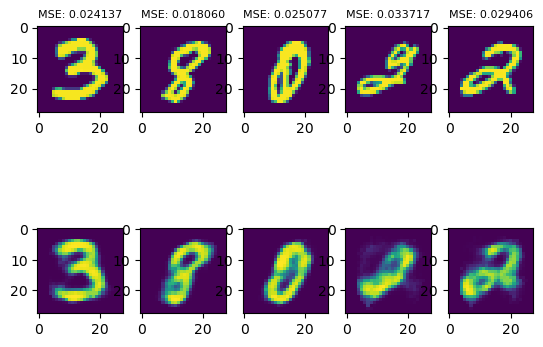

mean loss for anomaly data: 0.12769774183630944, std: 0.017985186582183104


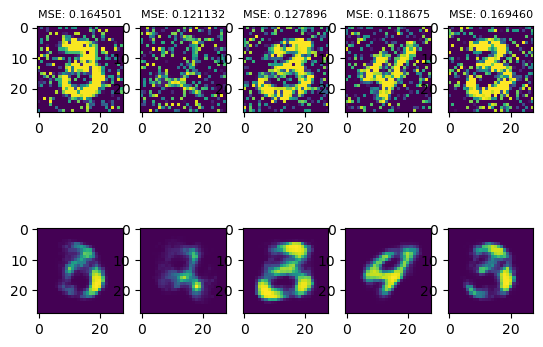

In [164]:
import matplotlib.pyplot as plt
import numpy as np

FIGURE_FONT_SIZE = 8
fig = plt.figure()
out = evaluate_image(normal_loader)
for i in range(1, 6):
        original_image, reconstrucet_image, loss, _ = out[i]
        ax1 = fig.add_subplot(2, 5, i)
        ax1.set_title(f"MSE: {loss:2f}", fontsize=FIGURE_FONT_SIZE) 
        plt.imshow(np.array(original_image).reshape(IMG_DIM, IMG_DIM))
        ax2 = fig.add_subplot(2, 5, i+5)
        # ax2.set_title(f"MSE: {loss:2f}", fontsize=FIGURE_FONT_SIZE) 
        plt.imshow(np.array(reconstrucet_image).reshape(IMG_DIM, IMG_DIM))

mean_loss = np.mean([element[2] for element in out])
std_loss = np.std([element[2] for element in out])
print(f"mean loss for normal data: {mean_loss}, std: {std_loss}")

plt.savefig(f"regular_training_normal_reconstruction_MNIST_noise_lvl{'03'}")
plt.show()
plt.close()

fig = plt.figure()
out = evaluate_image(anomaly_loader)
for i in range(1, 6):
        original_image, reconstrucet_image, loss, _ = out[i]
        ax1 = fig.add_subplot(2, 5, i)
        ax1.set_title(f"MSE: {loss:2f}", fontsize=FIGURE_FONT_SIZE) 
        plt.imshow(np.array(original_image).reshape(IMG_DIM, IMG_DIM))
        ax2 = fig.add_subplot(2, 5, i+5)
        # ax2.set_title(f"MSE: {loss:2f}", fontsize=FIGURE_FONT_SIZE) 
        plt.imshow(np.array(reconstrucet_image).reshape(IMG_DIM, IMG_DIM))

mean_loss = np.mean([element[2] for element in out])
std_loss = np.std([element[2] for element in out])

print(f"mean loss for anomaly data: {mean_loss}, std: {std_loss}")

plt.savefig(f"regular_training_anomaly_reconstruction_MNIST_noise_lvl{'03'}")
plt.show()
plt.close()

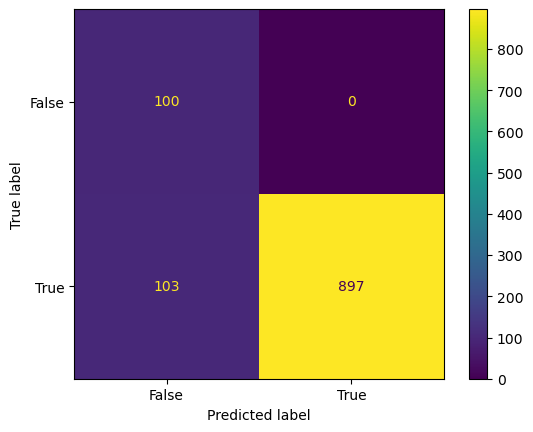

{'TN': 100,
 'FN': 103,
 'TP': 897,
 'FP': 0,
 'precision': 1.0,
 'recall': 0.897,
 'f1': 0.9457037427517132}

In [172]:
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score

preds, labels = predict(val_loader, threshold=THRESHOLD)

confusion_matrix = metrics.confusion_matrix(labels, preds)

normalized_confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1).reshape(2, 1)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True]) 
cm_display.plot()
plt.savefig(r"/home/anton/KTH/year5/5LSH0/Anomaly Detection with Autoencoder/plots/simple_ae/" + "confusion_matrix")
plt.show() 

In [187]:
from sklearn.metrics import roc_auc_score
import pandas as pd
metrics_dict = {}
metrics_dict["TN"] = confusion_matrix[0][0]
metrics_dict["FN"] = confusion_matrix[1][0] 
metrics_dict["TP"] = confusion_matrix[1][1]
metrics_dict["FP"] = confusion_matrix[0][1]

metrics_dict["precision"] = precision_score(labels, preds)
metrics_dict["recall"] = recall_score(labels, preds)
metrics_dict["f1"] = f1_score(labels, preds)
metrics_dict["roc"] = roc_auc_score(labels, preds)
metrics_dict["false alarm rate"] = metrics_dict["FP"] / (metrics_dict["FN"] + metrics_dict["TN"]) 

In [190]:
df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Score'])
df

,Metric,Score
0,TN,100.000000
1,FN,103.000000
2,TP,897.000000
3,FP,0.000000
4,precision,1.000000
5,recall,0.897000
6,f1,0.945704
7,roc,0.948500
8,false alarm rate,0.000000
